In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import time
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

pd

<module 'pandas' from 'D:\\Anaconda3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

# for symbol in NASDAQ100:
for symbol in ['NDX']:
#     if symbol == 'WDAY':
#         ignore = False
#     if ignore:
#         continue
#     datafile = spider.get_stock_data(symbol, timeframe)
#     print(datafile)
    pass

Wall time: 0 ns


In [3]:
%%time

### 业务设置

start_date = '2008-06-02'
start_date = '2017-01-03'
end_date = '2018-05-01'


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in NASDAQ100[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
    stock_df['pct_change'] = stock_df.close.pct_change(1)
    
    # 减少数据
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

Wall time: 25.9 s


In [5]:
%%time

show_df = None
show_df = stock_df_dict['NDX'].copy()

Wall time: 1e+03 µs


In [6]:
# %%time

# ### BT

# PROPERTY = 100000
# CASH = 100000
# hold = []
# recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

# yesterday = None

# show_df['CASH'] = pd.np.nan
# show_df['PROPERTY'] = pd.np.nan

# for today in pd.period_range(start=start_date, end=end_date, freq='D'):
#     if yesterday is None:
#         yesterday = today
#         continue

#     if today not in stock_df_dict['NDX'].index:
#         continue

#     show_df.loc[today, 'CASH'] = CASH
#     PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
#     show_df.loc[today, 'PROPERTY'] = PROPERTY

#     for order in hold:
        
#         is_sell_expect_rise = stock_df_dict[order[1]].loc[today, 'close'] > order[4]
        
#         if is_sell_expect_rise:
#             hold.remove(order)
#             CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
# #             print('%s win SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
#             recode_df = recode_df.append(
#                 {
#                     'date': today,
#                     'ops': 'SELL',
#                     'reason': 'WIN',
#                     'symbol': order[1],
#                     'count': order[2],
#                     'price': stock_df_dict[order[1]].loc[today, 'close'],
#                     'buy_price': order[3],
#                     'expect': order[4],
#                     'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
#                     'cash': CASH,
#                     'property': PROPERTY,
#                 },
#                 ignore_index=True
#             )

#         elif stock_df_dict[order[1]].loc[today, 'close'] / order[4] < 0.75:
#             hold.remove(order)
#             CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
# #             print('%s loss SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
#             recode_df = recode_df.append(
#                 {
#                     'date': today,
#                     'ops': 'SELL',
#                     'reason': 'LOSS',
#                     'symbol': order[1],
#                     'count': order[2],
#                     'price': stock_df_dict[order[1]].loc[today, 'close'],
#                     'buy_price': order[3],
#                     'expect': order[4],
#                     'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
#                     'cash': CASH,
#                     'property': PROPERTY,
#                 },
#                 ignore_index=True
#             )

#         elif today - order[0] > 30:
#             hold.remove(order)
#             CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
# #             print('%s TIMEUP SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
#             recode_df = recode_df.append(
#                 {
#                     'date': today,
#                     'ops': 'SELL',
#                     'reason': 'TIMEUP',
#                     'symbol': order[1],
#                     'count': order[2],
#                     'price': stock_df_dict[order[1]].loc[today, 'close'],
#                     'buy_price': order[3],
#                     'expect': order[4],
#                     'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
#                     'cash': CASH,
#                     'property': PROPERTY,
#                 },
#                 ignore_index=True
#             )
    
#     for symbol in NASDAQ100:
#         if today not in stock_df_dict[symbol].index:
#             continue
        
#         # buy drop wait rise back
#         is_buy = (stock_df_dict[symbol].loc[today, 'pct_change'] < -0.05)
        
#         # turtle buy N days
# #         N = 20
# #         is_buy = (stock_df_dict[symbol].loc[today, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).min()).loc[today])
        
#         if is_buy:
#             if stock_df_dict[symbol].loc[yesterday, 'close'] < stock_df_dict[symbol].shift(7).loc[yesterday, 'close']:
#                 continue
#             if CASH < 10000:
#                 continue
#             buy = int(CASH / 10 / stock_df_dict[symbol].loc[today, 'close'])
# #             buy = int(PROPERTY / 2 / stock_df_dict[symbol].loc[today, 'close'])
#             CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
#             hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']])
# #             print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']))
#             recode_df = recode_df.append(
#                 {
#                     'date': today,
#                     'ops': 'BUY',
#                     'reason': 'ENTER',
#                     'symbol': symbol,
#                     'count': buy,
#                     'price': stock_df_dict[symbol].loc[today, 'close'],
#                     'buy_price': stock_df_dict[symbol].loc[today, 'close'],
#                     'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
#                     'profit': 0,
#                     'cash': CASH,
#                     'property': PROPERTY,
#                 },
#                 ignore_index=True
#             )
    
#     show_df.loc[today, 'CASH'] = CASH
#     PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
#     show_df.loc[today, 'PROPERTY'] = PROPERTY

#     yesterday = today
            

# print(CASH)
# print(hold)
# print(PROPERTY)

# # s = 0
# # c = 0
# # for symbol in NASDAQ100:
# # # for symbol in ['TSLA', 'NVDA', 'BIDU', 'FB']:
# #     s_p = stock_df_dict[symbol].loc['2017-01-03', 'close']
# #     e_p = stock_df_dict[symbol].loc['2018-01-03', 'close']
# #     print(symbol, s_p, e_p, e_p / s_p)
# #     s += e_p / s_p
# #     c += 1

# # print(s / c)

# s_p = stock_df_dict['NDX'].loc[start_date, 'close']
# e_p = stock_df_dict['NDX'].loc[end_date, 'close']
# print('NDX', s_p, e_p, e_p / s_p)


In [7]:
%%time
# %%lprun

### Turtle
TURTLE_POS = 10
TURTLE_N = 20

is_happy_money = False
HAPPY_MONEY = 0
PROPERTY = 100000
CASH = 100000
hold = []
record_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])
count_day = 0
yesterday = None

show_df['CASH_T'] = pd.np.nan
show_df['PROPERTY_T'] = pd.np.nan

rolling_min_dict = {}
rolling_max_dict = {}

for symbol in NASDAQ100:
    rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'close'].rolling(TURTLE_N).min()
    rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'close'].rolling(TURTLE_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in stock_df_dict['NDX'].index:
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > 100000 * 2:
            hold = []
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
        
#     show_df.loc[today, 'CASH_T'] = CASH
#     PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
#     show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    for order in hold:
        is_sell = (stock_df_dict[order[1]].loc[today, 'close'] == rolling_min_dict[order[1]].loc[today])
        
        if is_sell:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s 售出 SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
#                   % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close'], CASH, PROPERTY))
            record_df = record_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    # 'expect': order[4],
                    'expect': 0,
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in NASDAQ100:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        if count_day < 20:
            is_buy = False
        else:
            is_buy = (stock_df_dict[symbol].loc[today, 'close'] == rolling_max_dict[symbol].loc[today])
#             is_buy = (stock_df_dict[symbol].loc[yesterday, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[yesterday])
        
        if is_buy:
            if CASH < PROPERTY / TURTLE_POS:
                continue
            buy = int(CASH / TURTLE_POS / stock_df_dict[symbol].loc[today, 'close'])
#             buy = int(CASH / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
#             CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy
            hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], 0])
#             print('%s 进场 BUY  %s * %d @ %f CASH=%d PROPERTY=%d' % 
#                   (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], CASH, PROPERTY))
            record_df = record_df.append(
                {
                    'date': today,
                    'ops': 'BUY',
                    'reason': 'ENTER',
                    'symbol': symbol,
                    'count': buy,
                    'price': stock_df_dict[symbol].loc[today, 'close'],
                    'buy_price': stock_df_dict[symbol].loc[today, 'close'],
                    'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['NDX'].loc[start_date, 'close']
e_p = stock_df_dict['NDX'].loc[end_date, 'close']
print('NDX', s_p, e_p, e_p / s_p)


13503.51199999993
0
135096.14199999993
[[Period('2017-11-22', 'D'), 'AMZN', 1, 1156.16, 0], [Period('2018-01-17', 'D'), 'ADBE', 7, 196.49, 0], [Period('2018-02-15', 'D'), 'ADBE', 30, 202.97, 0], [Period('2018-02-16', 'D'), 'INTU', 18, 171.69, 0], [Period('2018-02-20', 'D'), 'ADBE', 12, 202.98, 0], [Period('2018-02-27', 'D'), 'INTC', 27, 49.91, 0], [Period('2018-03-07', 'D'), 'ADBE', 8, 216.86, 0], [Period('2018-03-20', 'D'), 'ADBE', 6, 229.75, 0], [Period('2018-03-28', 'D'), 'SHPG', 57, 144.53, 0], [Period('2018-03-29', 'D'), 'SHPG', 49, 149.39, 0], [Period('2018-04-04', 'D'), 'DLTR', 91, 97.56, 0], [Period('2018-04-04', 'D'), 'HSIC', 117, 68.51, 0], [Period('2018-04-04', 'D'), 'ROST', 92, 78.63, 0], [Period('2018-04-04', 'D'), 'SHPG', 42, 153.52, 0], [Period('2018-04-05', 'D'), 'DLTR', 59, 99.0, 0], [Period('2018-04-05', 'D'), 'ROST', 66, 79.77, 0], [Period('2018-04-05', 'D'), 'SHPG', 30, 156.43, 0], [Period('2018-04-06', 'D'), 'SHPG', 31, 156.74, 0], [Period('2018-04-10', 'D'), 'DLTR

In [8]:
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
#     print(symbol, s_p, e_p, e_p / s_p)


In [9]:
# pd.set_option('display.max_rows', 1000)
# record_df
record_df.loc[record_df['ops']=='SELL'].sort_values(by=['profit'])

,date,ops,reason,symbol,count,price,buy_price,expect,profit,cash,property
631,2018-03-07,SELL,WIN,HAS,65,94.22,102.2200,0.0,-520,18633.7320,137951
674,2018-04-02,SELL,WIN,INTC,127,48.92,52.4800,0.0,-452.12,89491.0320,131801
670,2018-04-02,SELL,WIN,AMZN,5,1371.99,1451.0500,0.0,-395.3,76813.5320,131801
308,2017-09-08,SELL,WIN,CMCSA,121,38.21,41.1100,0.0,-350.9,18210.2170,122344
609,2018-02-15,SELL,WIN,LBTYA,73,34.05,38.4900,0.0,-324.12,62345.4620,132029
602,2018-02-08,SELL,WIN,CHTR,8,348.65,387.5000,0.0,-310.8,84185.7820,134236
628,2018-02-27,SELL,WIN,CMCSA,81,36.66,40.3200,0.0,-296.46,15225.0020,136159
297,2017-09-07,SELL,WIN,CMCSA,135,38.60,40.7300,0.0,-287.55,19594.6770,123196
298,2017-09-07,SELL,WIN,CMCSA,78,38.60,41.9000,0.0,-257.4,22605.4770,123196
438,2017-11-29,SELL,WIN,ADSK,12,109.34,127.7700,0.0,-221.16,25042.0920,142717


In [41]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = record_df.loc[record_df['ops']=='SELL', ['profit']].sort_values(by=['profit'])
# df

bins = [100 * x for x in range(-6, 32)]
# bins

cats = pd.cut(df['profit'], bins)
# cats

def get_stats(group):
    return {'count': group.count()}

grouped = df['profit'].groupby(cats)
bin_counts = grouped.apply(get_stats).unstack()
bin_counts.reset_index(inplace=True, drop=False)
bin_counts['profit'] = bin_counts['profit'].apply(str)
# bin_counts

# df['profit'].hist(bins=10)

# bin_counts.plot(kind='barh', alpha=0.5, rot=0)

display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600))

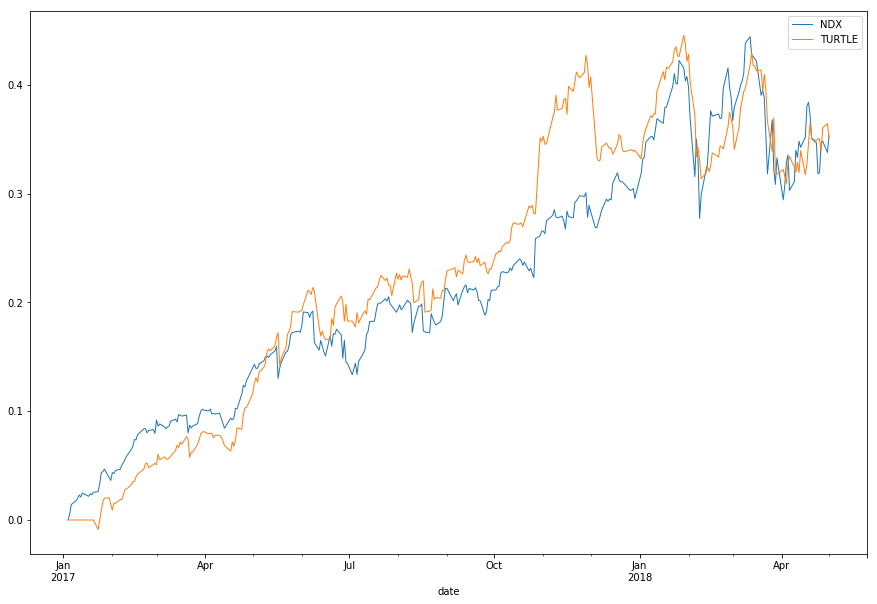

In [67]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()

# fc = df.iloc[0]['close']
# df.loc[:, ['close']]

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
df['PROPERTY_T'] = (df['PROPERTY_T'] - df.iloc[0]['PROPERTY_T']) / df.iloc[0]['PROPERTY_T']
# df['CASH_T'] = (df['CASH_T'] - df.head(1)['CASH_T'].values) / df.head(1)['PROPERTY_T'].values

ax = df.plot(kind='line', y='close', label='NDX', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY_T', secondary_y=False, label='TURTLE', linewidth=1, ax=ax)
# ax = df.plot(kind='line', y='CASH_T', secondary_y=True, label='TURTLE_CASH_T', linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()